In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [647]:
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd
import xarray as xr

from time import time
import glob
import warnings
import param
from dask import delayed

import numpy as np
import pandas as pd
import xarray as xr
from scipy.special import gammaln
from scipy.optimize import curve_fit, minimize
from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [188]:
data = pd.read_pickle('../data/drifters/posveldata_dens_all.pkl')

In [143]:
liste = []
for drif in data.index.unique():
    temp = data[data.index==drif].set_index('time')
    liste.append(xr.Dataset( temp , coords={'time':temp.index, 'id':drif}))    

In [410]:
ds = xr.concat( liste, dim='id')

In [411]:
ds['u'] = np.real( ds.uv )/100
ds['v'] = np.imag( ds.uv )/100

In [412]:
ds = ds.drop(['uv_filt','uv','sst','sal','lon_filt','lat_filt'])

In [744]:
ds.to_netcdf('../data/dask/test.nc')

In [745]:
ds = xr.open_dataset('../data/dask/test.nc',chunks=True, autoclose=True)

In [ ]:
ds = ds.persist()

In [ ]:
ds.u.plot(vmin=-1,vmax=1, cmap='RdBu_r')

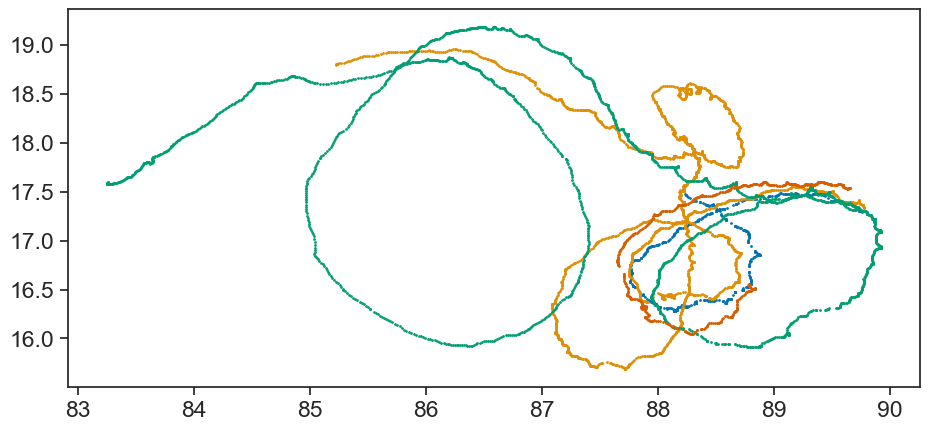

In [416]:
plt.scatter(ds.isel(id=0).lon,ds.isel(id=0).lat,1)
plt.scatter(ds.isel(id=1).lon,ds.isel(id=1).lat,1)
plt.scatter(ds.isel(id=2).lon,ds.isel(id=2).lat,1)
plt.scatter(ds.isel(id=4).lon,ds.isel(id=4).lat,1)

In [417]:
from scipy.special import comb
from itertools import combinations

In [418]:
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted( random.sample(range(n), r) )
    return tuple(pool[i] for i in indices)

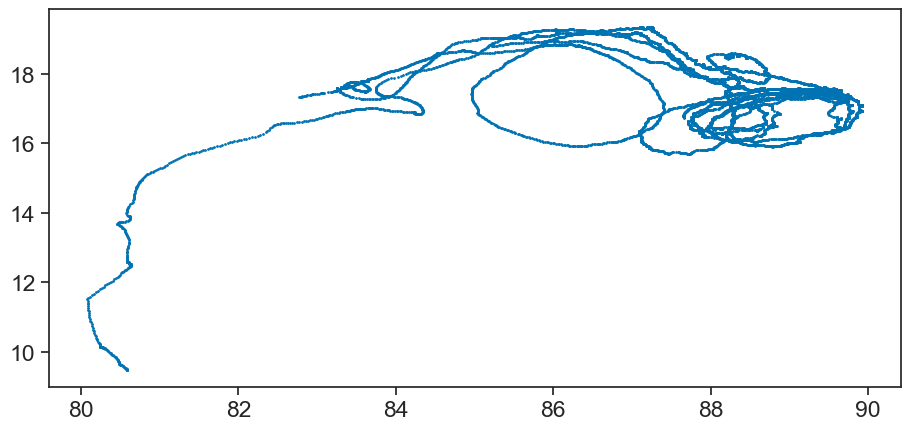

In [357]:
plt.scatter(dsp.lon,dsp.lat,1)

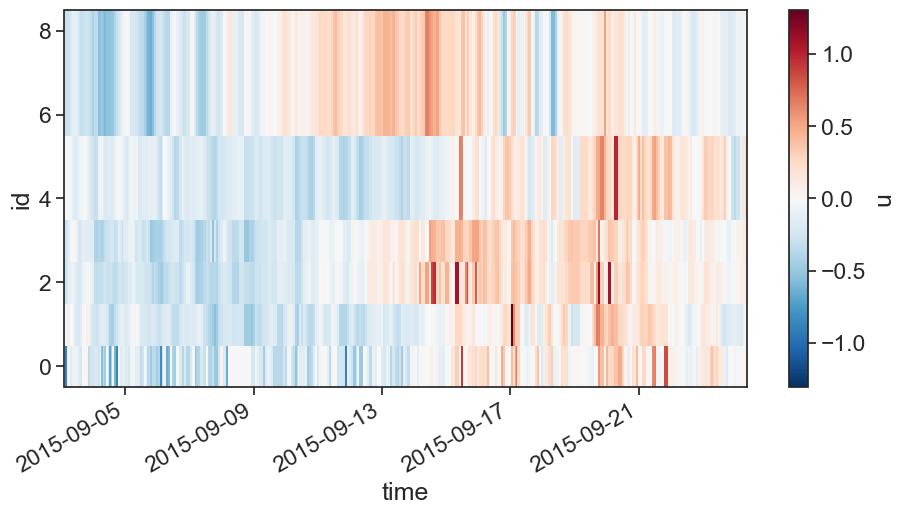

In [430]:
dsp.u.plot()

In [432]:
from deformtools.haversine import haversine
import scipy.linalg as la
from scipy.spatial import ConvexHull
import bottleneck as bn
import gsw

In [661]:
@delayed
def least_square_method(dspt):
        com = np.array( [bn.nanmean(dspt.lon),bn.nanmean(dspt.lat)])
        timeseries=False
        ncc = dspt.lon.size
        dlon=[]
        dlat=[]
        for i in range(ncc):
            # haversine(p1,p2)
            dlon.append(haversine( [dspt.lon[i],com[1]],com)*1000*np.sign(dspt.lon[i]-com[0]))
            dlat.append(haversine( [com[0],dspt.lat[i]],com)*1000*np.sign(dspt.lat[i]-com[1]))

        dlon=np.array(dlon)
        dlat=np.array(dlat)
        if not timeseries:
            R = np.mat( np.vstack( (np.ones((ncc)) ,dlon, dlat )).T )
            u0=np.mat(dspt.u.values).T
            v0=np.mat(dspt.v.values).T

            if (np.isnan( u0 ).sum()==0) & (np.isnan( v0 ).sum()==0) & (np.isnan( R ).sum()==0):
                A,_,_,_=la.lstsq(R,u0)
                B,_,_,_=la.lstsq(R,v0)
            else:
                A = np.nan*np.ones(ncc)
                B = np.nan*np.ones(ncc)

        points =np.vstack( [dlon,dlat] )
        if (np.isfinite(dlon).sum()==npol) and (np.isfinite(dlat).sum()==npol):
            # careful with nans
            cov = np.cov(points)
            w,v = np.linalg.eig(cov)
            aspect = bn.nanmin(w)/bn.nanmax(w)

            if aspect<0.99:
                ind = bn.nanargmax(w)
                angle = np.arctan(v[ind,1]/v[ind,0])*180/np.pi
                if (angle < 0):
                    angle += 360.
            else:
                self.angle=np.nan
        else:
            aspect=np.nan
            angle=np.nan
        
        
        dspt['ux'] = float(A[1])
        dspt['uy'] = float(A[2])
        dspt['vx'] = float(B[1])
        dspt['vy'] = float(B[2])
        dspt['aspect'] = aspect
        dspt['angle'] = angle

        return dspt
    
def compute_vort_etc(ds):
    ds['vort'] = (ds.vx-ds.uy)/gsw.f(40)
    ds['div'] = (ds.ux+ds.vy)/gsw.f(40)
    ds['strain'] = np.sqrt( (ds.ux-ds.vy)**2 +(ds.vx+ds.uy)**2 )/gsw.f(40)
    return ds

In [686]:
@delayed
def calc_lengths(dspt):
    lengths=[]
    ncc = dspt.lon.size
    r = combinations(np.arange(ncc), 2)

    k=0
    for i,j in r:
        lengths.append( haversine( [dspt.lon[i],dspt.lat[i]], [dspt.lon[j],dspt.lat[j]] ) )
        k+=1
    lengths=np.array(lengths)
    if np.isfinite(lengths).sum()==k:
        length = np.sqrt( np.mean(lengths**2) )
    else:
        length = np.nan
    dspt['length'] = length
    return dspt

In [663]:
npol=6
N = 45
combin=[]
for combi in combinations(np.arange(N),npol):
    combin.append(combi)

In [740]:
import dask

In [689]:
multi=[]
for combi in combin[110:120]:
    dsp = ds.isel(id=list(combi))
    dsp = dsp.dropna(dim='time',how='any')

    timeseries=[]
    for ti in dsp.time:
        timeseries.append(least_square_method(dsp.sel(time=ti)))

    timeseries1 = [calc_lengths(temp) for temp in timeseries]  
    timeseries2 = [temp.compute() for temp in timeseries1]
    ts = xr.concat(timeseries2, dim='time')
    multi.append(ts)
    
multi = xr.concat(multi, dim='clusters')

In [690]:
multi = compute_vort_etc(multi)

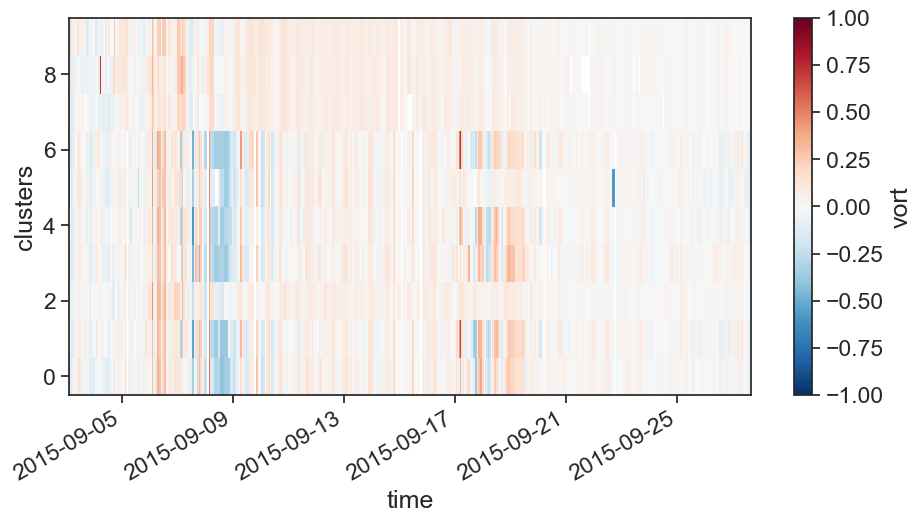

In [692]:
multi.vort.plot(vmin=-1,vmax=1,cmap='RdBu_r')

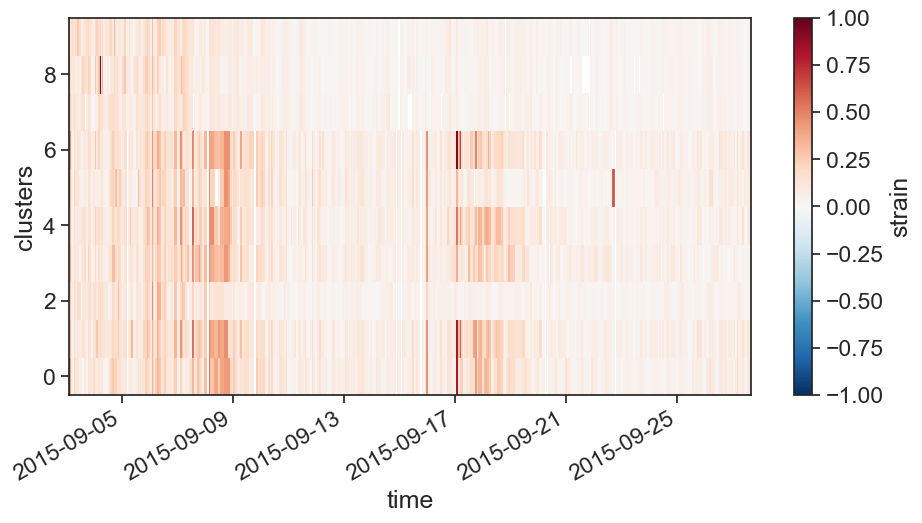

In [693]:
multi.strain.plot(vmin=-1,vmax=1,cmap='RdBu_r')

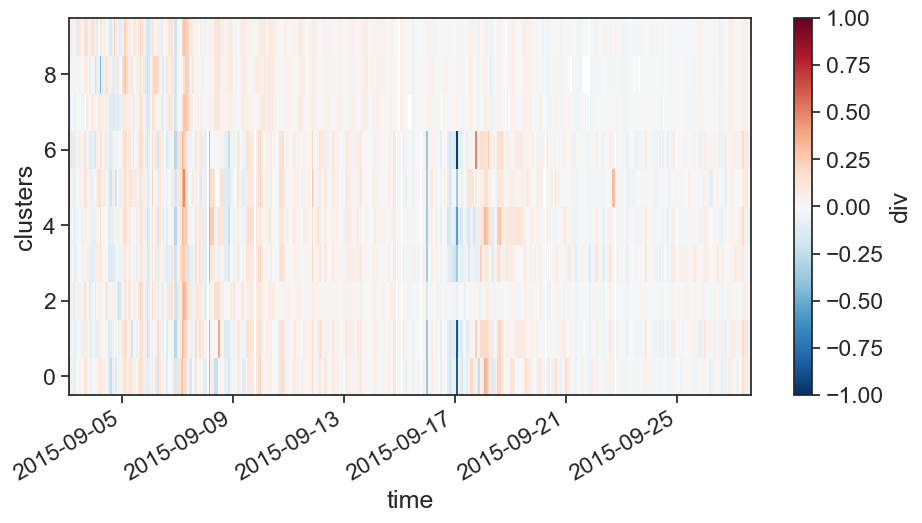

In [694]:
multi.div.plot(vmin=-1,vmax=1,cmap='RdBu_r')

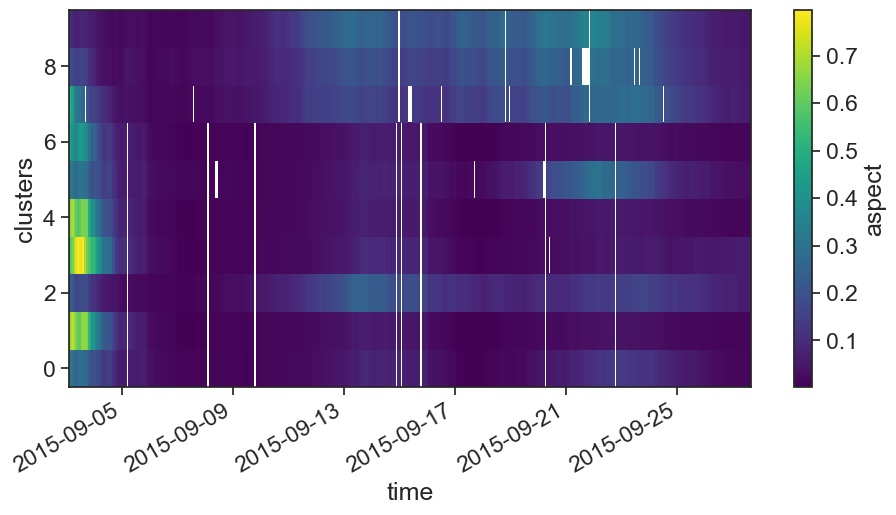

In [705]:
multi.aspect.plot()

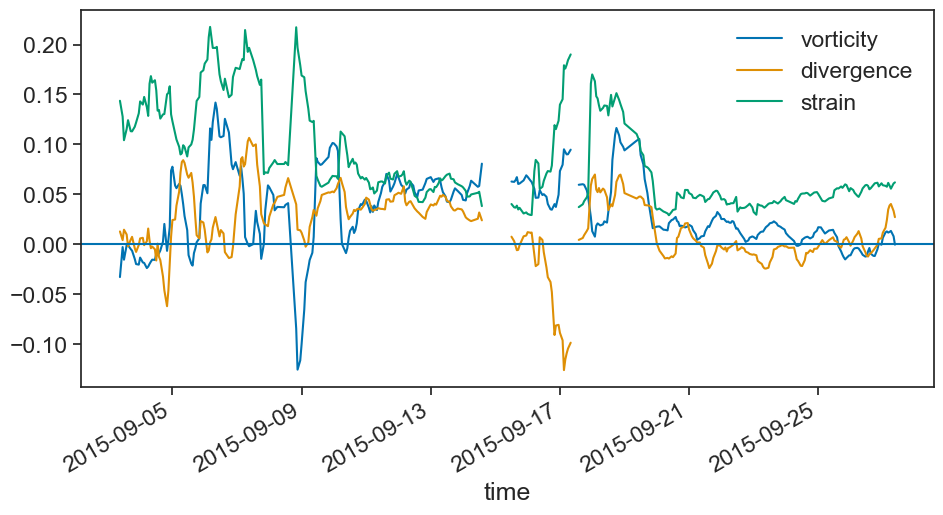

In [738]:
periods=10
multi.vort.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='vorticity')
multi.div.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='divergence')
multi.strain.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='strain')
plt.legend()
plt.axhline(0)

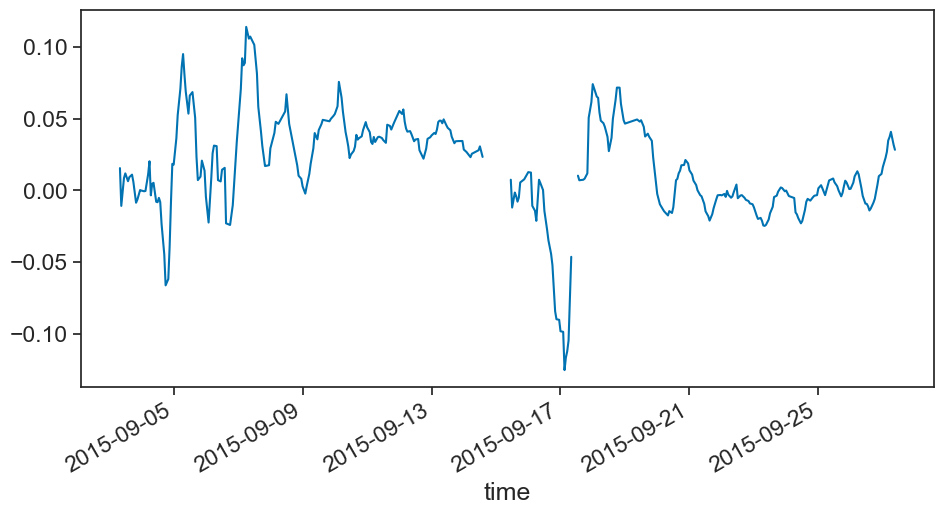